In [2]:
# Remove commenting for colab
#!pip install similaritymeasures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.7.0-py3-none-any.whl size=15452 sha256=16db5927ef7e4c67792322fb48e163daa0b69813b81fc17a02ee68c43c370a84
  Stored in directory: /root/.cache/pip/wheels/24/a6/80/6f1676caf08ab1b69d74c8a727c96fdd3903d891672b415008
Successfully built similaritymeasures


In [ ]:
# Remove commenting for colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Remove commenting for colab
#cd /content/drive/MyDrive/Hegarty Lab RA Folder/SilctonDSPSHQ-22Summer/NewDesktopDSPDataProcessing

/content/drive/MyDrive/Hegarty Lab RA Folder/SilctonDSPSHQ-22Summer/NewDesktopDSPDataProcessing


In [1]:
from analysis import Loader, Constants
from analysis import MovementAnalyzer, RotationAnalyzer
import pandas as pd
import numpy as np
from analysis import ShortcutMap, Strategy
import random

In [2]:
pd.set_option('display.max_column', 500)

constant = Constants(alt=False)

loader = Loader(constant, data_dir="data", extra_dir="extra", image_dir="images")
loader.load(learning=True)

In [3]:

shortcut_map = ShortcutMap(constant, "extra/shortcut_walls_1.csv", "extra/objects_1.csv", "shortcut_path_1.csv")
learning_map = ShortcutMap(constant, "extra/learning_walls_1.csv", "extra/objects_1.csv", learning=True)

strategy = Strategy("extra/strategy_map_1.txt", "extra/strategy_landmarks_1.txt")


ShortcutMap: Loaded 12 objects
Saving shortest distances to shortcut_path_1.csv
ShortcutMap: Loaded 12 objects
Saving shortest distances to learning_paths.csv
Saving shortest distances to reverse_learning_paths.csv


In [3]:
# Currently the movement analyzer can only handle normal (not alternative) trials, will add that later this week
movement_analyzer = MovementAnalyzer(loader, shortcut_map=shortcut_map, learning_map=learning_map, strategy=strategy)

# rotation analyzer gives the absolute angular error for each trial (both normal and alternative)

In [0]:
efficiencies = movement_analyzer.calculate_efficiency_for_all_subjects()
#print(efficiencies)

failures = movement_analyzer.calculate_failure_for_all_subjects()
#print(failures)

In [5]:

rotation_analyzer = RotationAnalyzer(loader)
errors = rotation_analyzer.calculate_estimation_error_for_all_subjects(3, 23)
errors = pd.DataFrame(errors).transpose()
print(errors)

               3          4          5           6           7          8    
AB04KO  11.331300    6.27880   27.20580  153.112460   78.058450  101.97802  \
ab25fa  77.062400    8.50247    4.45858    6.455700    4.868800   24.82810   
AL07ME  23.620700   63.71260   38.44200   38.358350   23.547154   54.65460   
AL15MA  63.391210   70.76240  132.92815    0.594300  111.602900   53.78100   
AN15PO   9.542070   93.07804   31.58800   49.323980   80.785600    0.27080   
...           ...        ...        ...         ...         ...        ...   
VA17HA  66.997170   25.57110   57.02920    5.781200   60.578100   53.55799   
VA25JI  24.597388   55.42433   55.72409   98.662300    5.118800    8.77880   
XI03ME  77.642000   93.08550   83.67390   55.425984   80.962400   18.35460   
XI31SH  13.444100   36.30827   23.48130    4.320700   23.776100   16.09141   
YI11LI   8.728700  156.66244   50.62800   18.611980   12.162000   62.62391   

                9           10         11         12         13

In [6]:
# Check if the error is correctly distributed
import pandas as pd

# assuming errors is your dataframe and the third column contains the data
bin_ranges = [0, 60, 120, 180, 240, 300, 330]  # Define bin ranges
bin_names = ['0-60', '60-120', '120-180', '180-240', '240-300', '300-330']  # Define bin names

for i in range(20):  # For each of the first 20 columns
    errors[f'bin_range_{i}'] = pd.cut(errors.iloc[:, i], bins=bin_ranges, labels=bin_names, include_lowest=True)
    bin_counts = errors[f'bin_range_{i}'].value_counts().sort_index()

    print(f"For column {i}:")
    # Check if '0-60' is the largest bin
    if bin_counts.idxmax() == '0-60':
        print(f"'0-60' is the largest bin for column {i}\n")
    else:
        print(f"'0-60' is not the largest bin for column {i}. The largest bin is {bin_counts.idxmax()}\n")


For column 0:
'0-60' is the largest bin for column 0

For column 1:
'0-60' is the largest bin for column 1

For column 2:
'0-60' is the largest bin for column 2

For column 3:
'0-60' is the largest bin for column 3

For column 4:
'0-60' is the largest bin for column 4

For column 5:
'0-60' is the largest bin for column 5

For column 6:
'0-60' is the largest bin for column 6

For column 7:
'0-60' is the largest bin for column 7

For column 8:
'0-60' is the largest bin for column 8

For column 9:
'0-60' is the largest bin for column 9

For column 10:
'0-60' is the largest bin for column 10

For column 11:
'0-60' is the largest bin for column 11

For column 12:
'0-60' is the largest bin for column 12

For column 13:
'0-60' is the largest bin for column 13

For column 14:
'0-60' is the largest bin for column 14

For column 15:
'0-60' is the largest bin for column 15

For column 16:
'0-60' is the largest bin for column 16

For column 17:
'0-60' is the largest bin for column 17

For column 1

In [5]:
# calculate Frechet Distances for each trajectory
frechet_distances = movement_analyzer.calculate_frechet_for_all_subjects()

Frechet processing: AB04KO
Frechet processing: ab25fa
Frechet processing: AL07ME
Frechet processing: AL15MA
Frechet processing: AN15PO
Frechet processing: AU23KI
Frechet processing: AU24FR
Frechet processing: AV16ME
Frechet processing: BE10AH
Frechet processing: BI05IL
Frechet processing: BR17CH
Frechet processing: br19br
Frechet processing: br19fr
Frechet processing: BR20CO
Frechet processing: BR21FR
Frechet processing: BR22FA
Frechet processing: ca16he
Frechet processing: CH06ZA
Frechet processing: ch12cr
Frechet processing: CI13GA
Frechet processing: CL26RO
Frechet processing: DA17HA
Frechet processing: EM21TA
Frechet processing: EV23VA
Frechet processing: gi01ca
Frechet processing: GR25BE
Frechet processing: HA05KO
Frechet processing: HA25SH
Frechet processing: HE29FI
Frechet processing: IS04LI
Frechet processing: JA13SI
Frechet processing: JA21AC
Frechet processing: Ji18Fe
Frechet processing: jo21ho
Frechet processing: JU04BA
Frechet processing: KA15AN
Frechet processing: KE17FI
F

In [6]:
frechet_table = pd.DataFrame.from_dict(frechet_distances).transpose()

# assume your data is stored in a pandas DataFrame called df
# with participant names as index and trial numbers as columns

# define a function to check if the shortcut value is minimum among ('shortcut', 'shortcut_reversed', 'lean', 'topo')

def is_shortest(col):
    shortcuts = [col['learn'], col['learn_reversed'], col['shortcut'], col['topo']]
    check = col['shortcut'] == min(shortcuts) and col['failure'] == 0
    return check

def process_each_subject(row):
    return row.apply(is_shortest).sum()

# use pandas' apply method to apply the is_shortest function to each row of the DataFrame
# then use pandas' sum method to count the number of rows where failure == 0 and shortcut is the minimum value
num_shortcut = frechet_table.apply(lambda row: row.apply(is_shortest).sum(), axis=1)

# change the row indexing to a column
num_shortcut = num_shortcut.reset_index()
# change the only column name to 'solution_index'
num_shortcut = num_shortcut.rename(columns={0:'num_shortcut','index':'subID'})

In [7]:
eff = pd.DataFrame.from_dict(efficiencies).transpose()
eff = eff.reset_index().rename(columns = {'index':'subID'})
sub_failure = pd.DataFrame(failures,index=[0]).transpose().reset_index().rename({'index':'subID',0:'num_failures'},axis=1)
point_err = pd.DataFrame.from_dict(errors).transpose()
point_err = point_err.reset_index().rename(columns = {'index':'subID'})
eff['eff_avg'] = eff.iloc[:,1:].mean(axis=1)
point_err['point_avg'] = point_err.iloc[:,1:].mean(axis=1)
dsp_sub = eff[['subID','eff_avg']].merge(point_err[['subID','point_avg']],on='subID').merge(sub_failure,on='subID').merge(num_shortcut,on='subID')
dsp_sub['solution_index'] = dsp_sub['num_shortcut']/(20-dsp_sub['num_failures'])
dsp_sub

,subID,eff_avg,point_avg,num_failures,num_shortcut,solution_index
0,AB04KO,1.945944,66.202485,4,9,0.562500
1,ab25fa,1.246909,19.929991,0,18,0.900000
2,AL07ME,1.144492,26.662507,0,17,0.850000
3,AL15MA,2.053032,70.339982,9,7,0.636364
4,AN15PO,1.733405,40.245003,1,10,0.526316
...,...,...,...,...,...,...
68,VA17HA,1.833280,61.975002,3,6,0.352941
69,VA25JI,1.224228,23.450032,0,16,0.800000
70,XI03ME,1.843504,56.909992,5,8,0.533333
71,XI31SH,1.353089,21.097493,1,15,0.789474


<Axes: >

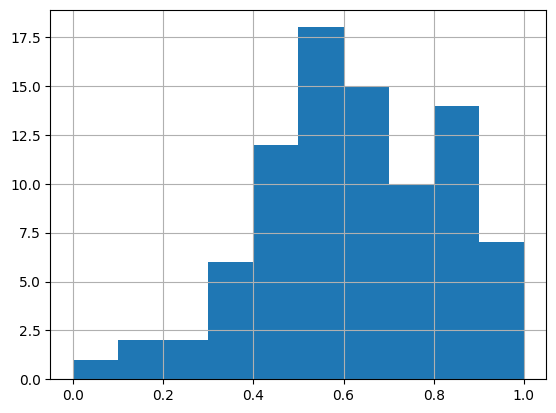

In [12]:
dsp_sub.solution_index.hist()

In [8]:
dsp_sub.to_csv("dsp_sub_1.csv",index=False)

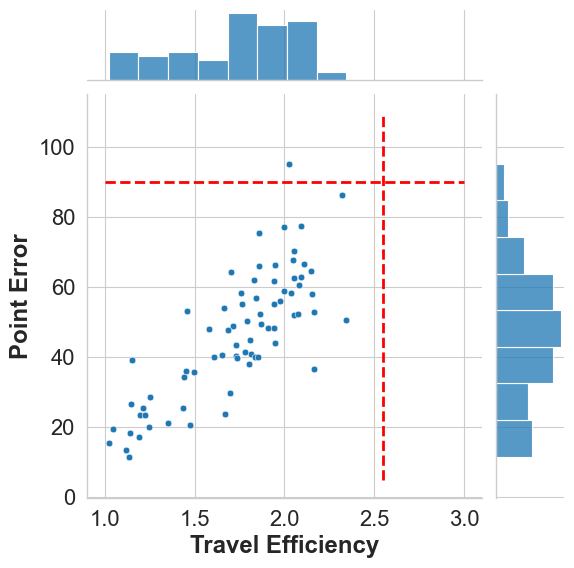

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=dsp_sub, y="point_avg", x="eff_avg")
g.ax_joint.set_ylabel('Point Error', fontweight='bold')
g.ax_joint.set_xlabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([1,3], [90,90], 'r--', linewidth = 2)
g.ax_joint.plot([2.55,2.55],[5,110] , 'r--', linewidth = 2)
plt.show()

In [9]:
movement_analyzer.export_distance_summary("distance_summary_1.csv")

In [10]:
movement_analyzer.export_processed_data_for_all_subjects(folder="processed_data_1")

AB04KO, 3
AB04KO, 4
AB04KO, 5
AB04KO, 6
AB04KO, 7
AB04KO, 8
AB04KO, 9
AB04KO, 10


KeyboardInterrupt: 

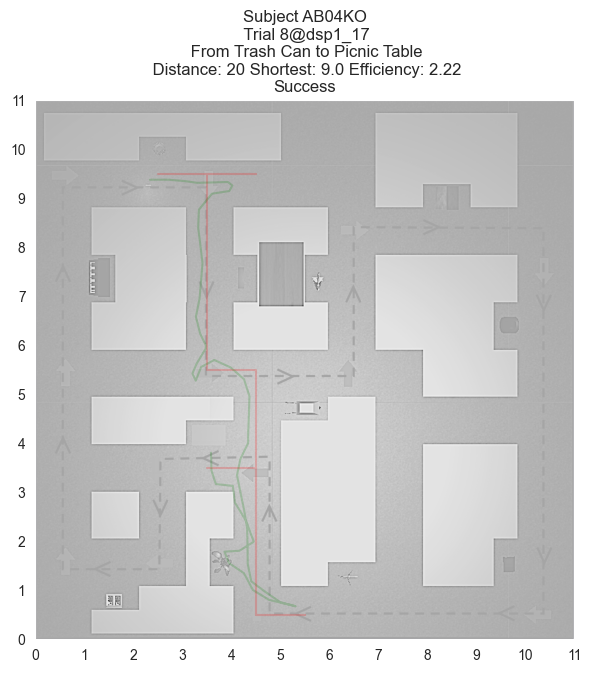

In [11]:
# can set up excluding
movement_analyzer.plots_for_all_subjects(folder="path_plot_1", save_only = True)

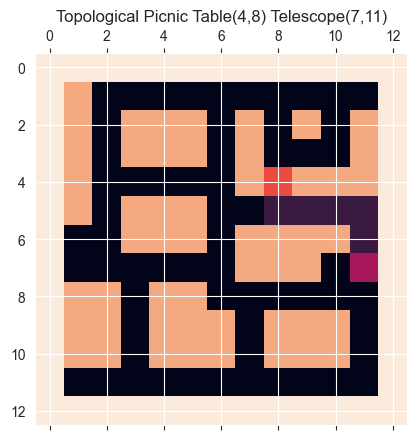

In [12]:
movement_analyzer.plot_all_topological_paths(folder="topo_plot_1", save_only=True)